In [125]:
import math as m
import numpy as np
from numpy.linalg import inv
import seaborn as sns
from copy import deepcopy
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

# Задание 1. АИНА

Смоделируем измерения Yk c ошибками, имеющими норамльное распределение N(0, D)

Начальные условия:

In [126]:
n = 30 # количество измерений, 30-40
h = 6 # шаг измерений, 3-6 с
v = 0.2 # скорость, 0.2-0.3 км/с
sko = 1 # СКО, 1-2 км
m = 0 # математическое ожидание
alpha = 0.05 # уровень значимости доверительного интервала
probability = 1 - alpha # вероятность попадания величины в промежуток (-u_a; u_a)
ur_znach = 1.96 # значение по таблице 
# Ф(x) = (1 - alpha) / 2 = 0.95 / 2 = 0.475

Создадим список с тактами, в которые происходят измерения:

In [127]:
t = np.array([(h * i) for i in range(n)]) #такты, в которые происходят измерения

In [128]:
print(t)

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174]


Зададим начальные координаты

In [129]:
x_0 = 50
y_0 = 100

Вычислим координаты в каждый момент времени:

In [130]:
x_izm = np.array([x_0 + v * i * np.cos(30) for i in t ])
y_izm = np.array([y_0 + v * i * np.sin(30) for i in t ])

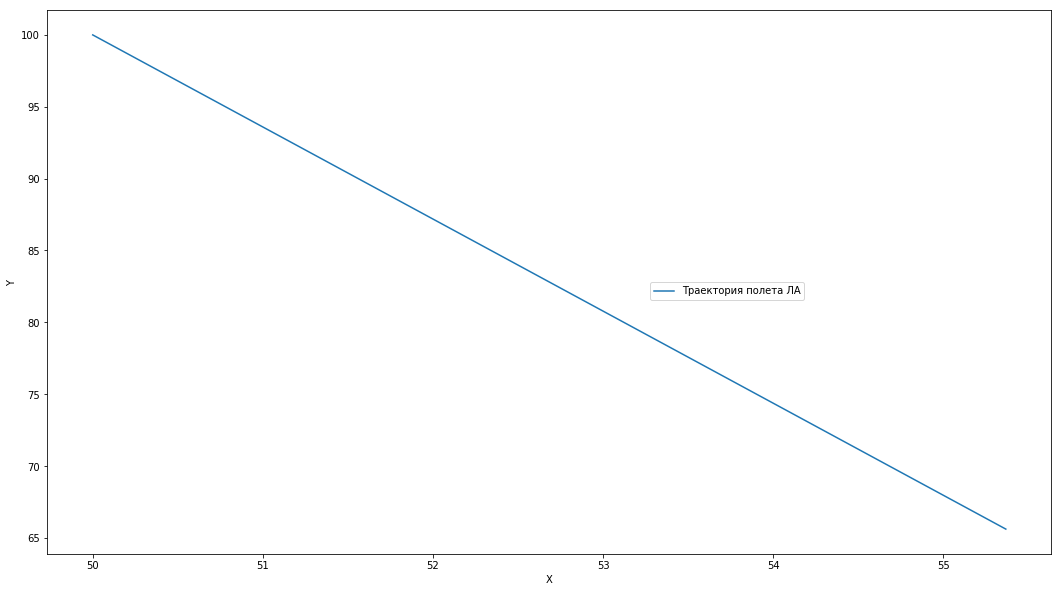

In [131]:
plt.figure(figsize=(18, 10))
plt.plot(x_izm, y_izm, label = 'Траектория полета ЛА')
plt.ylabel('Y')
plt.xlabel('X')
plt.legend(bbox_to_anchor=(0.6, 0.5), loc='upper left', borderaxespad=0.)
plt.show()

Сформируем набор истинных измерений (без учета ошибок), как быдто мы знаем точную дальность r ЛА в каждый такт

In [132]:
r_real = (np.array(x_izm)**2 + np.array(y_izm)**2)**0.5

In [133]:
# r_real

### Пункт 1. Ошибки с нормальным распределением

Добавим на измерения ошибки, распределенные нормально

С помощью встроенной функции на питон, выдающей случаные величины по заданному распределению, получим вектор ошибок, распределенных нормало

In [134]:
Wk = np.random.normal(0, 1, 30) 

In [135]:
Wk

array([-1.04697122, -0.66192316, -1.959017  , -1.16192328, -1.17772489,
       -0.94149869, -0.42624373, -0.05283142, -0.22940228, -1.58258903,
       -0.97911088,  0.02480984, -0.77867162,  1.4870301 , -0.74420205,
        0.7016448 ,  0.55088368, -1.58878627, -0.58338014,  0.10970593,
        1.24708559,  2.29178965,  0.28226501, -0.20722546, -0.97339309,
        1.73629373,  0.68667287, -0.94865607, -0.69639455, -1.87421246])

Сформируем окончательный набор с ошибками, распределенными нормально:

In [136]:
Yk_1 = r_real + np.array(Wk)

In [137]:
# Yk_1

Изобразим на рисунке истинную дальность и измерения:

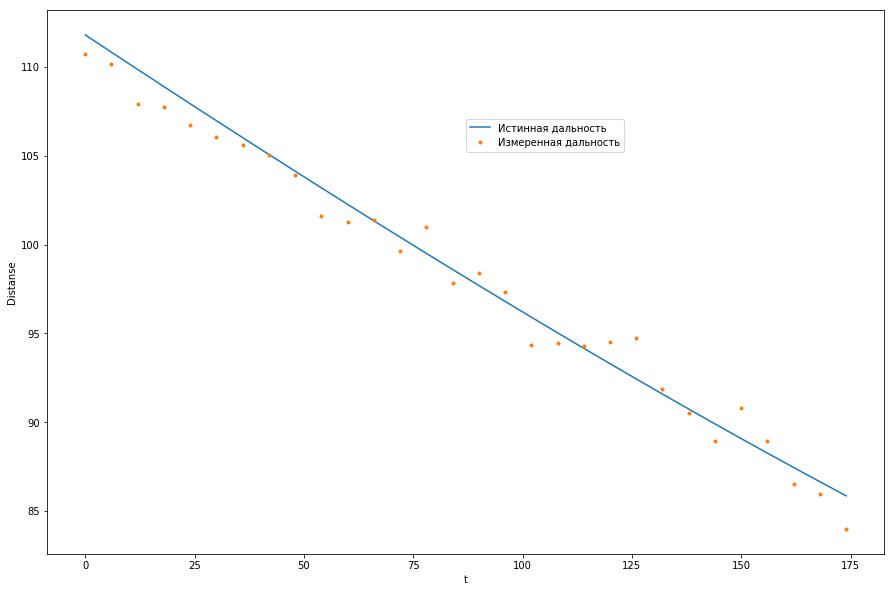

In [138]:
plt.figure(figsize=(15, 10))
plt.plot(t, r_real, label = 'Истинная дальность')
plt.plot(t, Yk_1, '.', label = 'Измеренная дальность')
plt.ylabel('Distanse')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

# Задание 2.

Решение аналитически, матричным способом

In [139]:
A = sum(Yk_1)
B = sum(t * Yk_1)
ResC = np.array([A, B])

In [140]:
c11 = n
c12 = sum(np.array(t))
c21 = sum(np.array(t))
c22 = sum(np.array(t)**2)
C = np.array([[c11, c12], [c21, c22]])

In [141]:
C1 = np.array([[A, c12], \
               [B, c22]])
C2 = np.array([[c11, A],\
               [c21, B]])

In [142]:
C1det = np.linalg.det(C1)
C2det = np.linalg.det(C2)
Cdet = np.linalg.det(C)

In [143]:
thet1 = C1det / Cdet
thet2 = C2det / Cdet
print('После решения матричного уравнения получает оцененные параметры с помощью МНК:\n', thet1, thet2)
r = thet1 + thet2 * np.array(t)

После решения матричного уравнения получает оцененные параметры с помощью МНК:
 110.51040507492516 -0.14296681439870987


Построение доверительного интервала

Посчитаем границы промежутка (-u_a; u_a):

In [144]:
Aa = np.matrix([np.ones(n),t]).transpose() #. матрица А как у влада и ани в отчете про мнк
I = np.eye(n) # единичная матрица
sigma = np.var(Wk)

In [145]:
# тут считает вектор дисперсии для доверительного интервала
def dispersion_count(t_arr):
    Disp = []
    for i in t:
        h_t = np.matrix([1, i]).transpose()
        a = h_t.transpose().dot(inv(Aa.transpose().dot(Aa))).dot(Aa.transpose())
        d_temp = a.dot(sigma).dot(I).dot(a.transpose())
        Disp.append(d_temp.item(0))
    Disp = np.array(Disp)
    return Disp

In [146]:
Disp = dispersion_count(t)

Дисперсия МНК-оценки, выборочная дисперсия

Доверительный интервал:

In [147]:
r_uleft = r - ur_znach * Disp**0.5 - 1
r_urght = r + ur_znach * Disp**0.5 + 1

Графики истинной, измеренной, оцененной дальности, доверительного интервала

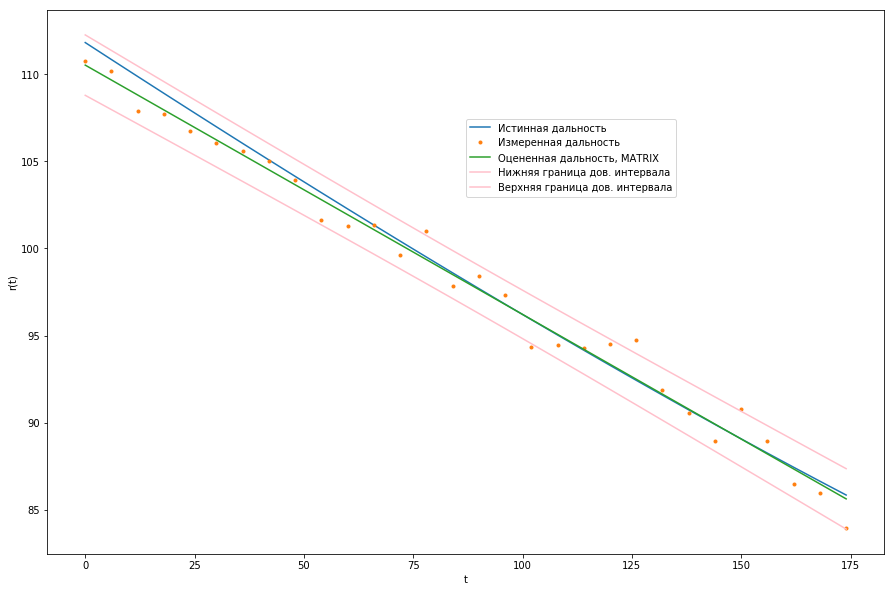

In [148]:
plt.figure(figsize=(15, 10))
plt.plot(t, r_real, label = 'Истинная дальность')
plt.plot(t, Yk_1, '.', label = 'Измеренная дальность')
# plt.plot(t, r0, label = 'Оцененная дальность, Dima')
plt.plot(t, r, label = 'Оцененная дальность, MATRIX')
plt.plot(t, r_uleft, 'pink', label = 'Нижняя граница дов. интервала')
plt.plot(t, r_urght, 'pink', label = 'Верхняя граница дов. интервала')
plt.ylabel('r(t)')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

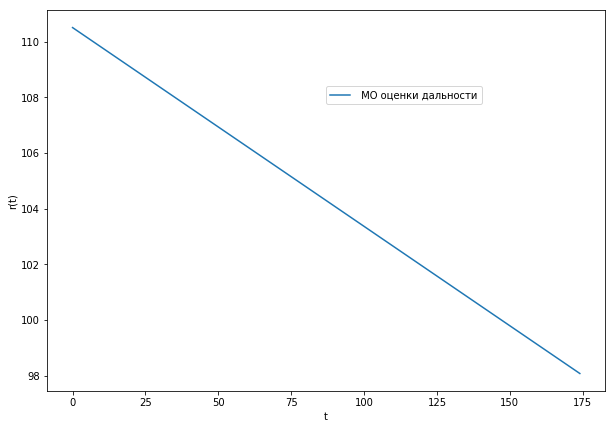

In [149]:
M = []
for i in range(1,n+1):
    M.append(np.mean(r[:i]))
M = np.array(M)

plt.figure(figsize=(10, 7))
plt.plot(t, M, label = ' МО оценки дальности')
plt.ylabel('r(t)')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

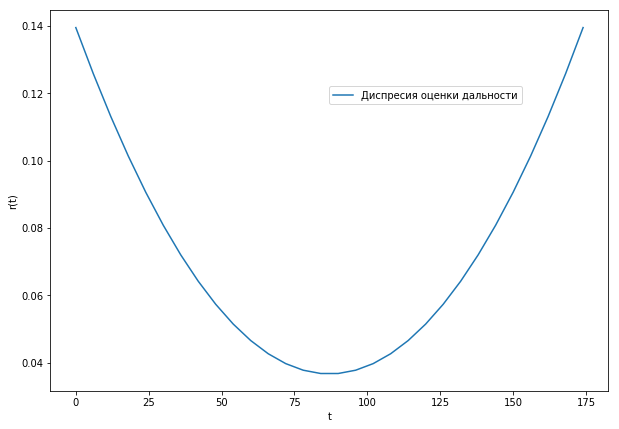

In [150]:
plt.figure(figsize=(10, 7))
plt.plot(t, Disp, label = 'Диспресия оценки дальности')
plt.ylabel('r(t)')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

# Задание 3.

Решим задачу поиска параметров матричным способом

In [151]:
d11 = n
d12 = sum(t)
d13 =sum(t**2)
d21 = sum(t)
d22 = sum(t**2)
d23 = sum(t**3)
d31 = sum(t**2)
d32 = sum(t**3)
d33 = sum (t**4)
D = np.array([[d11, d12, d13], \
             [d21, d22, d23], \
             [d31, d32, d33]])
print(D)

[[        30       2610     307980]
 [      2610     307980   40872600]
 [    307980   40872600 5785342704]]


In [152]:
A_1 = sum(Yk_1)
A_2 = sum(Yk_1 * t)
A_3 = sum(Yk_1 * t**2)
A_ = np.array([A_1, A_2, A_3])
print(A_)

[2.94216877e+03 2.44401238e+05 2.81795442e+07]


In [153]:
teta_1, teta_2, teta_3 = np.linalg.solve(D, A_)
print(teta_1, teta_2, teta_3)
r_ = teta_1 + teta_2 * t + teta_3 * t**2 / 2

110.17368478300824 -0.13094108968739018 -6.91133604098834e-05


Аналогично заданию 2 построим графические данные для задания 3

Границы промежутка:

Дисперсия МНК-оценки, выборочная дисперсия

In [154]:
Aa = np.matrix([np.ones(n),t, t**2/2]).transpose() #. матрица А как у влада и ани в отчете про мнк
I = np.eye(n) # единичная матрица
sigma = np.var(Wk)

In [155]:
# тут считает вектор дисперсии для доверительного интервала
def dispersion_count(t_arr):
    Disp = []
    for i in t:
        h_t = np.matrix([1, i, i**2/2]).transpose()
        a = h_t.transpose().dot(inv(Aa.transpose().dot(Aa))).dot(Aa.transpose())
        d_temp = a.dot(sigma).dot(I).dot(a.transpose())
        Disp.append(d_temp.item(0))
    Disp = np.array(Disp)
    return Disp

In [156]:
Disp = dispersion_count(t)

Графики истинной, измеренной, оцененной дальности, доверительного интервала

In [157]:
r_uleft_3 = r_ - ur_znach * Disp**0.1
r_urght_3 = r_ + ur_znach * Disp**0.1

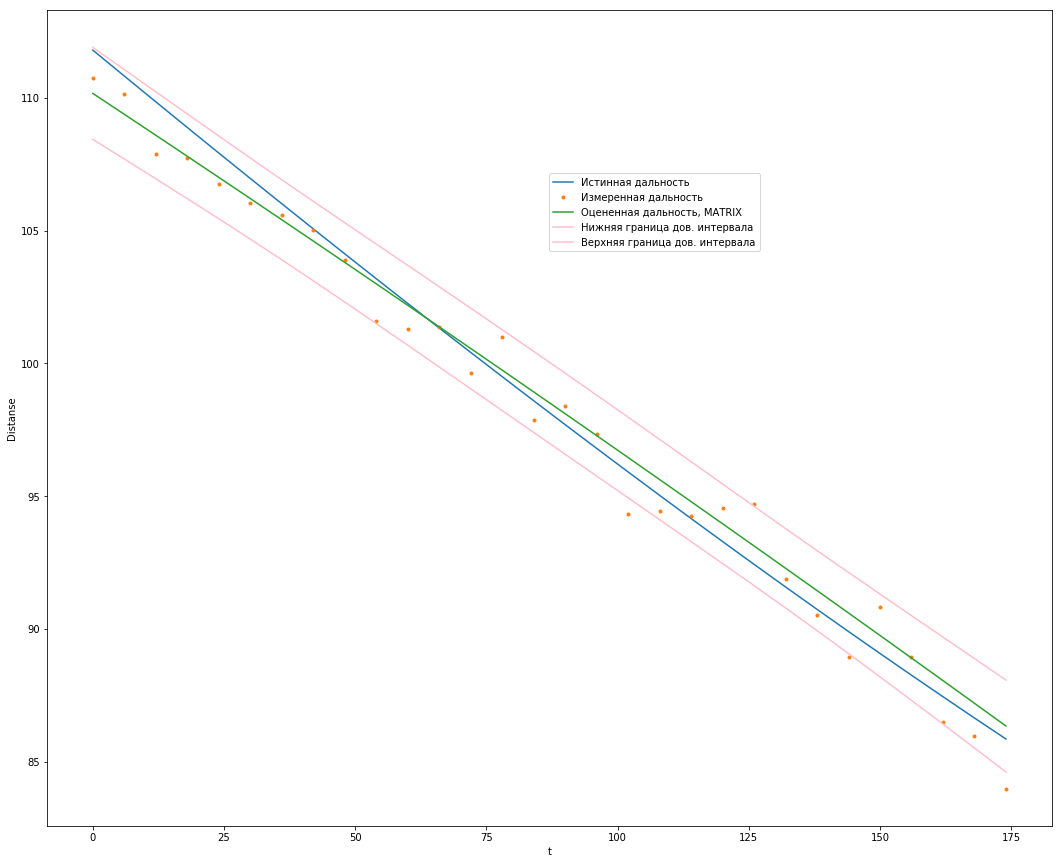

In [158]:
plt.figure(figsize=(18, 15))
plt.plot(t, r_real, label = 'Истинная дальность')
plt.plot(t, Yk_1, '.', label = 'Измеренная дальность')
# plt.plot(t, r0, label = 'Оцененная дальность, Dima')
plt.plot(t, r_, label = 'Оцененная дальность, MATRIX')
plt.plot(t, r_uleft_3, 'pink', label = 'Нижняя граница дов. интервала')
plt.plot(t, r_urght_3, 'pink', label = 'Верхняя граница дов. интервала')
plt.ylabel('Distanse')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

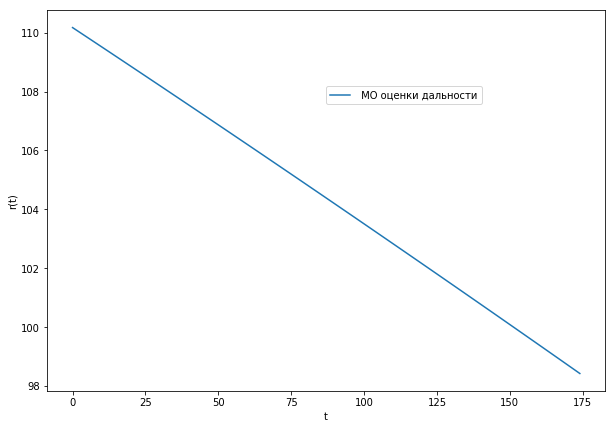

In [159]:
M = []
for i in range(1,n+1):
    M.append(np.mean(r_[:i]))
M = np.array(M)

plt.figure(figsize=(10, 7))
plt.plot(t, M, label = ' МО оценки дальности')
plt.ylabel('r(t)')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

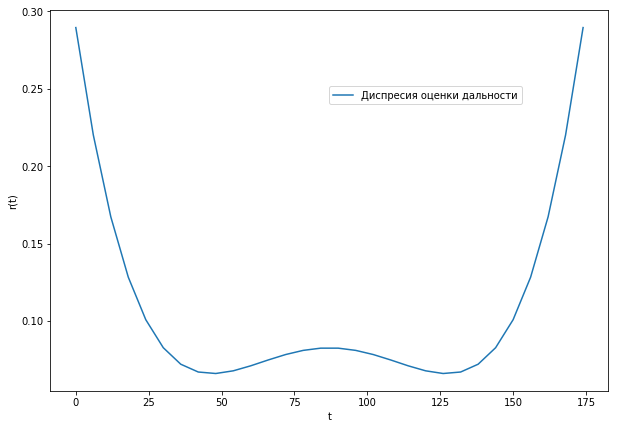

In [160]:
plt.figure(figsize=(10, 7))
plt.plot(t, Disp, label = 'Диспресия оценки дальности')
plt.ylabel('r(t)')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

# Задание 4

На уровне значимости $\alpha$ проверить гипотезу $H_{0} : \{\theta_{3}=0\}$


Найдем t-критическое по таблице распределения Стьюдента на уровне значимости $\alpha = 0,05$. 
$t_{n-k}$, где $n$ - число измерений (величина выборки), $k$ - число оцениваемых параметров
$t_{30-3}=t_{27}=2,0518$ 

In [161]:
t_cr = 2.0518
varRes = sum([(xi - np.mean(r_))**2 for xi in r_]) / (len(r_) -1)
print(varRes)
T = np.matrix([np.ones(n), t, t**2/2])
T = T.transpose()
COV = varRes * inv(T.transpose().dot(T))
print(COV)
se_teta = COV[2, 2]**0.5
print('Доверительный интервал для teta_3:')
print('[', teta_3 - t_cr * se_teta, ',', teta_3 + t_cr * se_teta, ']')

52.33747862110773
[[ 1.37807958e+01 -3.11281375e-01  2.93108639e-03]
 [-3.11281375e-01  9.75416459e-03 -1.04681657e-04]
 [ 2.93108639e-03 -1.04681657e-04  1.20323744e-06]]
Доверительный интервал для teta_3:
[ -0.0023197775096050477 , 0.002181550788785281 ]


-0.49538926824584506


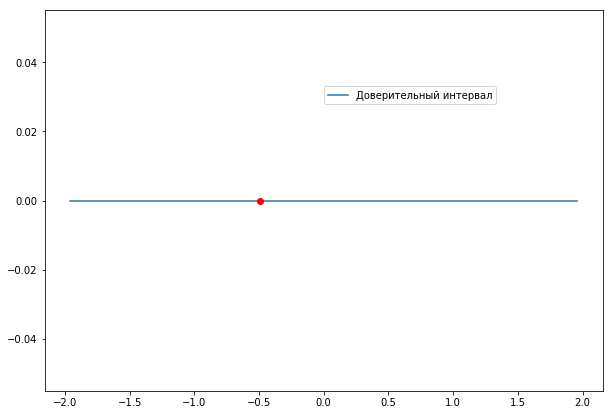

In [162]:
H3def = inv(Aa.transpose().dot(Aa))
Ktheta = 0.01 * H3def
Dispers = Ktheta[2, 2]
T_ = teta_3 / Dispers**0.4
print(T_)
Ul = -1.95996 # границы доверительного интервала
Ur = - Ul # границы доверительного интервала


plt.figure(figsize=(10, 7))
plt.plot([Ul, Ur], [0,0], label = 'Доверительный интервал')
plt.plot(T_, 0, 'o', color='red')

plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

In [163]:
# plt.figure(figsize=(10, 7))
# plt.plot([Ul, Ur], [0,0], label = 'Доверительный интервал')
# plt.plot(T_, 0, 'o', color='red')
# # 
# plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

# plt.show()

Так как 0 попадает в доверительный интервал, построенный для $\theta_{3}=0$, гипотеза $H_{0} : \{\theta_{3}=0\}$ не отклоняется.

Для аппроксимации достаточно выбрать модель простой линейной регрессии,  так как гипмотеза о тета=0 подтвердилась, значит, третий оцененный параметр не влияет на уравнение дальности (так как ЛА по условию задачи движется равномерно и прямолинейно )

# Задание 5

Выбрана модель простой линейной регрессии. Построим для нее гистограмму вектора остатков

Остатки:

In [164]:
residual = r_ - Yk_1
# r_ - оцененная дальность с помощью МНК (зеленая прямая)
#Yk_1 - измеренная дальность (оранжевые точки)
# print(residual)

In [165]:
# скопировала в rr наши остатки, чтобы их не изменить случайно
rr = deepcopy(residual) 
# сортирую по возрастанию
rr = sorted(rr)
left = min(rr)
right = max(rr)
bins_s = [i for i in np.linspace(left, right, 6)]
def gaussian(x, mu, sigma):
     return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (x - mu)**2 / sigma**0.5)

/Users/synthtron/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


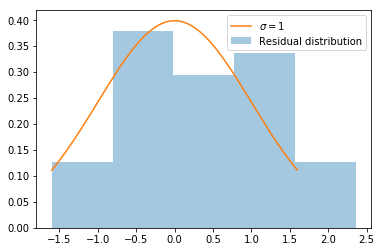

In [194]:
sns_plot = sns.distplot(residual, bins=bins_s, kde=False, norm_hist=True, label = 'Residual distribution')
fig = sns_plot.get_figure()

xs = np.arange(left, -left, 0.001) # Сетка значений по оси абсцисс.
p2, = plt.plot(xs, [gaussian(x, 0, 1) for x in xs], label='$\sigma = 1$')
plt.legend()
plt.show()

# Задание 6

На уровне значимости $\alpha = 0.05$ по критерию хи-квадрат проверить гипотезу о том, что ошибки подчиняются нормальному распределению $N(0,\sigma)$

Если $\chi^{2}_{1} <= \chi^{2} <= \chi^{2}_{2}$, то гипотеза выполняется

# Переписать теорию как у Влада. Написать свои значения критерия. Для остатков по нормальному распределению напишу ниже:
(эти вычисления я кидала в таблице)

In [167]:
t_nabl = 3.673325177
t_cr = 7.81473

t_nabl < t_cr => гипотеза принимается

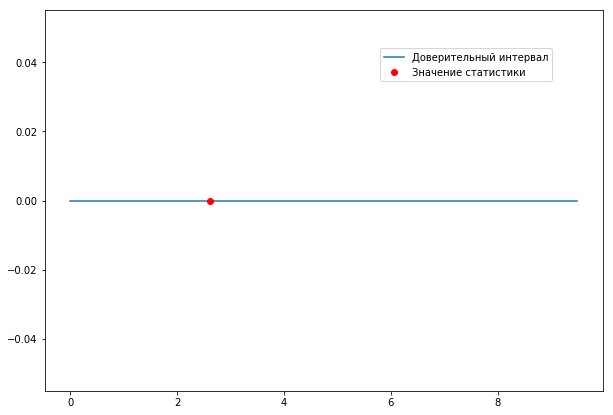

In [234]:
import scipy as scp
from scipy.stats import chisquare
quantile_ = 9.4877

bins_s
interv1 = []
interv2 = []
interv3 = []
interv4 = []
interv5 = []
for i in residual:
    if bins_s[0] < i < bins_s[1]:
        interv1.append(i)
    elif bins_s[1] < i < bins_s[2]:
        interv2.append(i)
    elif bins_s[2] < i < bins_s[3]:
        interv3.append(i)
    elif bins_s[3] < i < bins_s[4]:
        interv4.append(i)
    elif bins_s[4] < i < bins_s[5]:
        interv5.append(i)
freq_interv1 = len(interv1)
freq_interv2 = len(interv2)
freq_interv3 = len(interv3)
freq_interv4 = len(interv4)
freq_interv5 = len(interv5)

probsIntoSegment = []
for i in range(1, 6):
    f_ = (scp.erf(bins_s[i]) + 1) / (2 * (2**0.5))
    s_ = (scp.erf(bins_s[i - 1]) + 1) / (2 * (2**0.5))
    probsIntoSegment.append((f_ - s_) * 1)
probsIntoSegment = np.array(probsIntoSegment) 

cntlhs = (scp.erf(residual[0] / 2**0.5) + 1) / 2
cntrhs = (scp.erf(residual[29] / 2**0.5) + 1) / 2
# print(cntlhs, cntrhs)

drob1 = (freq_interv1 - n * probsIntoSegment[0])**2 / (n * probsIntoSegment[0])
drob2 = (freq_interv2 - n * probsIntoSegment[1])**2 / (n * probsIntoSegment[1])
drob3 = (freq_interv3 - n * probsIntoSegment[2])**2 / (n * probsIntoSegment[2])
drob4 = (freq_interv4 - n * probsIntoSegment[3])**2 / (n * probsIntoSegment[3])
drob5 = (freq_interv5 - n * probsIntoSegment[4])**2 / (n * probsIntoSegment[4])
stat_distr = (n * cntlhs + drob1 + drob2 + drob3 + drob4 + drob5 + n * (1 - cntrhs))/12


plt.figure(figsize=(10, 7))
plt.plot([0, quantile_], [0,0], label = 'Доверительный интервал')
plt.plot(stat_distr, 0, 'o', color='red', label = 'Значение статистики')
plt.legend(bbox_to_anchor=(0.6, 0.9), loc='upper left', borderaxespad=0.)

plt.show()